# Tutorial 1: Stereo-Seq : MOSTA E16.5 E2S5

In [ ]:
# %%
# Analyze MOSTA E16.5 E2S5 Spatial Transcriptomics data with SpacGPA.
# Data source: https://db.cngb.org/stomics/mosta/
# MOSTA E16.5 E2S5 is a mouse embryo sample at embryonic day 16.5 generated with Stereo-seq.

In [ ]:
# Import SpacGPA and other required packages.
import SpacGPA as sg
import scanpy as sc
import matplotlib.pyplot as plt
import os

In [ ]:
# Set the working directory to your local path.
workdir = '..'
os.chdir(workdir)

### Part 1: Gene program analysis via SpacGPA ####

In [ ]:
# Load spatial transcriptomics data.
adata = sc.read_h5ad("data/Stereo-seq/MOSTA/E16.5_E2S5.MOSTA.h5ad")
adata.var_names_make_unique()
print(adata)

AnnData object with n_obs × n_vars = 132481 × 28555
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - A1cf', 'Regulon - Agap2', 'Regulon - Alx1', 'Regulon - Alx3', 'Regulon - Arid3a', 'Regulon - Arnt', 'Regulon - Arnt2', 'Regulon - Arx', 'Regulon - Atf1', 'Regulon - Atf2', 'Regulon - Atf3', 'Regulon - Atf4', 'Regulon - Atf5', 'Regulon - Atf6b', 'Regulon - Atf7', 'Regulon - Bach2', 'Regulon - Barhl1', 'Regulon - Barhl2', 'Regulon - Barx1', 'Regulon - Barx2', 'Regulon - Bcl6', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe22', 'Regulon - Bhlhe40', 'Regulon - Bmyc', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Carf', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cebpa', 'Regulon - Cebpb', 'Regulon - Cebpd', 'Regulon - Cebpe', 'Regulon - Cebpg', 'Regulon - Cenpb', 'Regulon - Chd1', 'Regulon - Ckmt1', 'Regulon - Clock', 'Regulon - Creb1', 'Regulon - Creb3', 'Regulon - Cre

In [ ]:
# Preprocessing: use raw counts from layers['count'], then library-size normalize and log1p-transform.
adata.X = adata.layers['count']
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=10)
print(adata.X.shape)

(130944, 25068)


In [ ]:
# Construct the co-expression network using SpacGPA (Gaussian graphical model).
ggm = sg.create_ggm(adata,project_name = "E16.5_E2S5")  

Please Normalize The Expression Matrix Before Running!
Loading Data.

Running all calculations on GPU (if available).
Using single precision (float32) for all calculations.
Using chunk size of 5000 for efficient computation

Computing the number of cells co-expressing each gene pair...
Computing covariance matrix...
Computing Pearson correlation matrix...

Calculating partial correlations in 15711 iterations.
Number of genes randomly selected in each iteration: 2000
Iteration: 15711/15711, Avg loop time: 0.0391 s, Elapsed time: 10.53 min, Estimated time left: 0.00 min.                  
All iterations completed.

Performing FDR control...
Randomly redistribute the expression distribution of input genes...

Calculate correlation between genes after redistribution...

Computing the number of cells co-expressing each gene pair...
Computing covariance matrix...
Computing Pearson correlation matrix...

Calculating partial correlations in 15711 iterations.
Number of genes randomly selected i

In [ ]:
# Show statistically significant co-expression gene pairs.
print(ggm.SigEdges.head(5))

     GeneA    GeneB      Pcor  SamplingTime         r  Cell_num_A  Cell_num_B  \
0  Gm42418  Gm26561  0.161319           102  0.692325      130944      126654   
1     Nnat   Marcks  0.021694            89  0.165198       93205       90285   
2     Nrep     Nnat  0.022605           106  0.221623       86082       93205   
3    Rpl18   Rpl13a  0.033076           118  0.159847      113324      126615   
4    Rpl19   Rpl13a  0.023570           126  0.132455       93794      126615   

   Cell_num_coexpressed     Project  
0                126654  E16.5_E2S5  
1                 68132  E16.5_E2S5  
2                 65409  E16.5_E2S5  
3                110812  E16.5_E2S5  
4                 92034  E16.5_E2S5  


In [ ]:
# Identify gene programs using the MCL-Hub algorithm (set inflation to 2).
ggm.find_modules(method='mcl-hub',inflation=2)


Find modules using MCL-Hub...
Current Pcor: 0.02
Total significantly co-expressed gene pairs: 60459
Iteration: 38, Max change: 0.00000000 
Converged at iteration 38.

2 modules were removed due to their linear or radial topology structure out of 76 modules.


In [ ]:
# Inspect the top 5 identified gene programs.
print(ggm.modules_summary.head(5))

  module_id  size  num_genes_degree_ge_2  \
0        M1   312                    255   
1        M2   264                    241   
2        M3   261                    210   
3        M4   236                    188   
4        M5   203                    157   

                                           all_genes  
0  Ttn, Neb, Myl1, Myh8, Gm28653, Tceal7, Tnnt3, ...  
1  Dmkn, S100a14, Perp, Krt1, Sfn, Asprv1, Krt19,...  
2  Apoa2, Gm45774, Afp, Apoa1, Mt2, Car2, Mt1, Rb...  
3  Col3a1, Col1a2, Col1a1, Sparc, Lgals1, Postn, ...  
4  Mapt, Ina, Tubb3, Nnat, Crmp1, Stmn2, Tuba1a, ...  


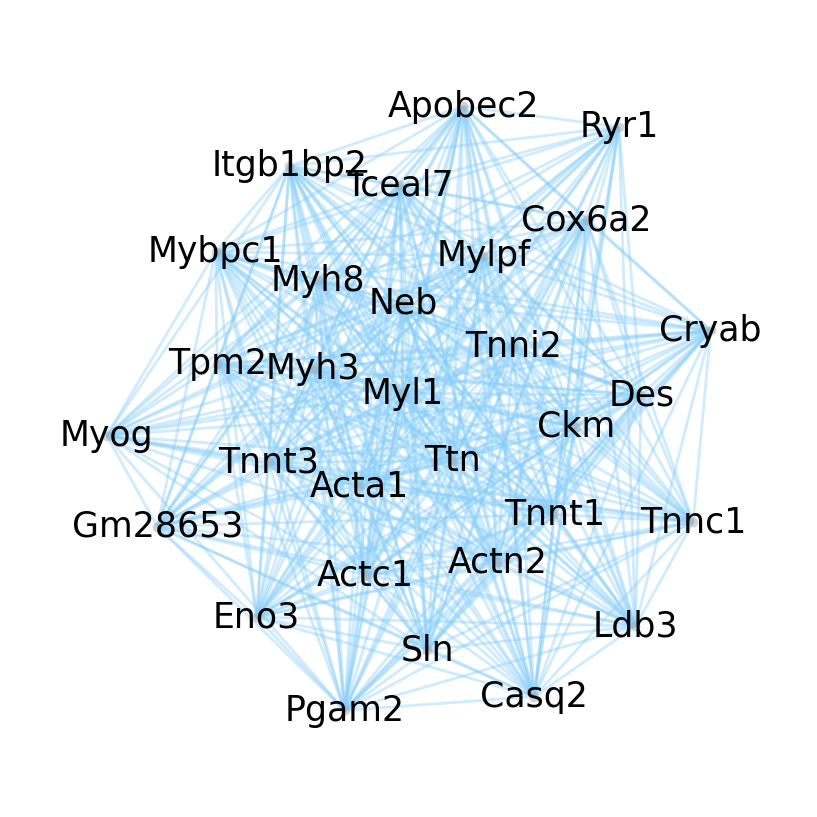

In [ ]:
# Visualize the subnetwork of program M1 (top 30 genes by degree/connectivity for readability).
M1_edges = ggm.get_module_edges('M1')
M1_anno = ggm.get_module_anno('M1')
sg.module_network_plot(
    nodes_edges = M1_edges,
    nodes_anno = M1_anno,
    seed=2 # Fix layout randomness for reproducibility
)

In [ ]:
# Gene Ontology (GO) enrichment analysis with BH FDR control and p-value threshold 0.05.
ggm.go_enrichment_analysis(species='mouse',padjust_method="BH",pvalue_cutoff=0.05)


Reading GO term information for |mouse|...

Start GO enrichment analysis ...
Found 175 significant enriched GO terms in M74        
GO enrichment analysis completed. Found 19447 significant enriched GO terms total.


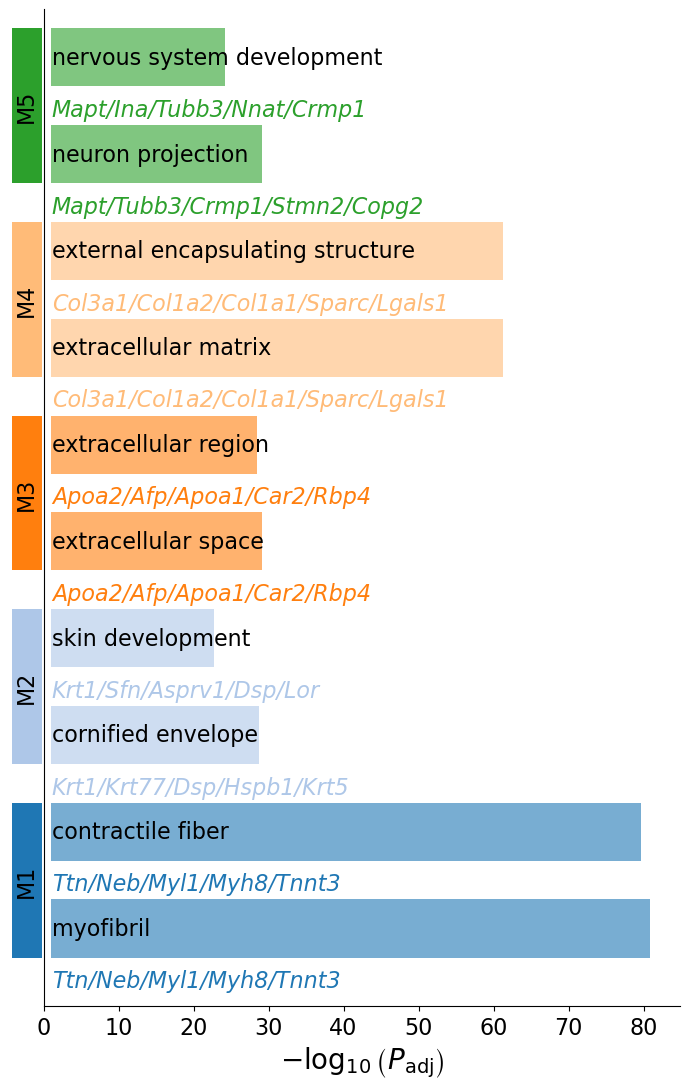

In [ ]:
# Visualize top enriched GO terms for programs M1–M5.
sg.module_go_enrichment_plot(ggm, top_n_modules=5, go_per_module=2)

In [ ]:
# Mammalian Phenotype (MP) Ontology enrichment analysis with BH FDR control and p-value threshold 0.05.
ggm.mp_enrichment_analysis(species='mouse',padjust_method="BH",pvalue_cutoff=0.05)


Reading MP term information for |mouse|...

Start MP enrichment analysis ...
Found 280 significant enriched MP terms in M74       
MP enrichment analysis completed. Found 12480 significant enriched MP terms total.


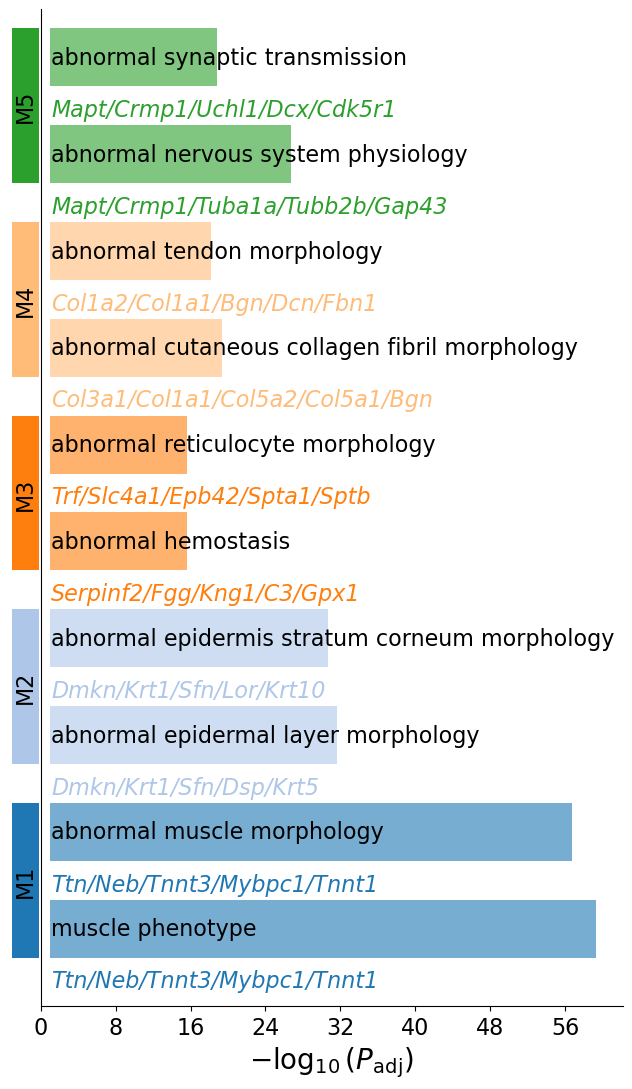

In [ ]:
# Visualize top enriched MP terms for programs M1–M5.
sg.module_mp_enrichment_plot(ggm, top_n_modules=5, mp_per_module=2)

module_id                      M1
module_size                   312
go_rank                         1
go_id                  GO:0030016
go_category    cellular_component
go_term                 myofibril
Name: 0, dtype: object


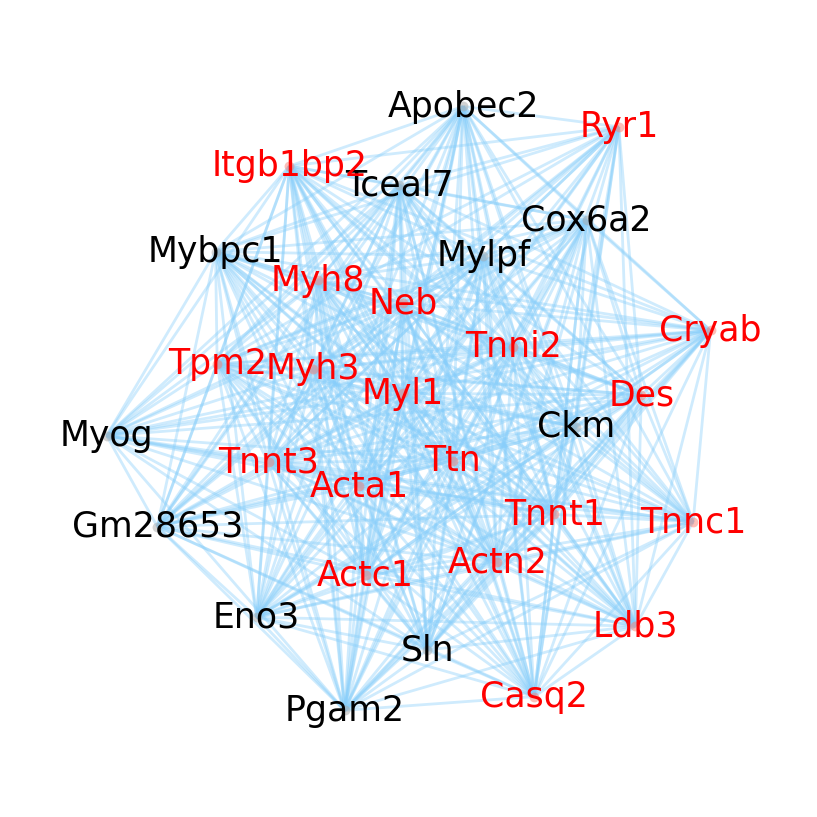

module_id                    M1
module_size                 312
mp_rank                       1
mp_id                MP:0005369
mp_term        muscle phenotype
Name: 0, dtype: object


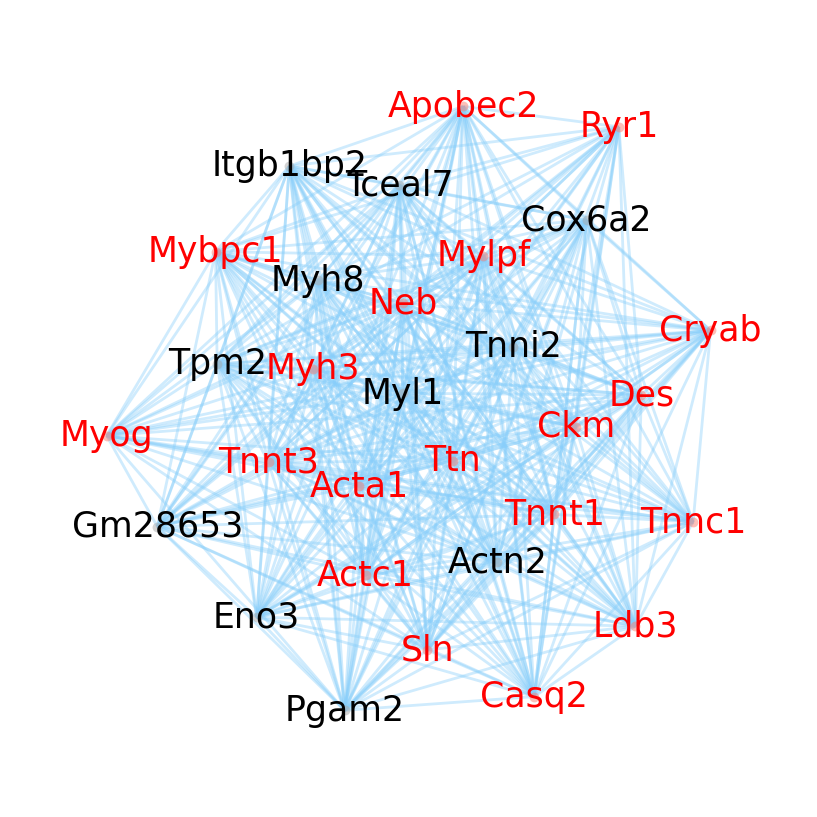

In [ ]:
# Visualize the M1 network with nodes highlighted by a selected GO or MP term ID.
M1_edges = ggm.get_module_edges('M1')
M1_anno = ggm.get_module_anno('M1')
print(ggm.go_enrichment.iloc[0, :6])
sg.module_network_plot(
    nodes_edges = M1_edges,
    nodes_anno = M1_anno,
    highlight_anno="GO:0030016",
    seed=2
)
print(ggm.mp_enrichment.iloc[0, :5])
sg.module_network_plot(
    nodes_edges = M1_edges,
    nodes_anno = M1_anno,
    highlight_anno="MP:0005369",
    seed=2
)

In [ ]:
# Print a summary of the GGM analysis.
print(ggm)

View of ggm object: E16.5_E2S5
MetaInfo:
  Gene Number: 25068
  Sample Number: 130944
  Pcor Threshold: 0.02

Results:
  SigEdges: DataFrame with 60459 significant gene pairs
  modules: 74 modules with 4923 genes
  modules_summary: DataFrame with 74 rows
  FDR: Exists



In [ ]:
# Save the GGM object to HDF5 for later reuse.
sg.save_ggm(ggm, "data/MOSTA_E16.5_E2S5.ggm.h5")
# Then you can reload it via:
# ggm = sg.load_ggm("data/MOSTA_E16.5_E2S5.ggm.h5")



#### Part 2: Spot annotation based on program expression ####

In [ ]:
# Compute per-spot expression scores of each gene program.
sg.calculate_module_expression(adata, ggm)


Calculating module expression using top 30 genes...

Calculating gene weights based on degree...
Storing module information in adata.uns['module_info']...

Assigning colors to 74 modules...

Total 74 modules' average expression calculated and stored in adata.obs and adata.obsm


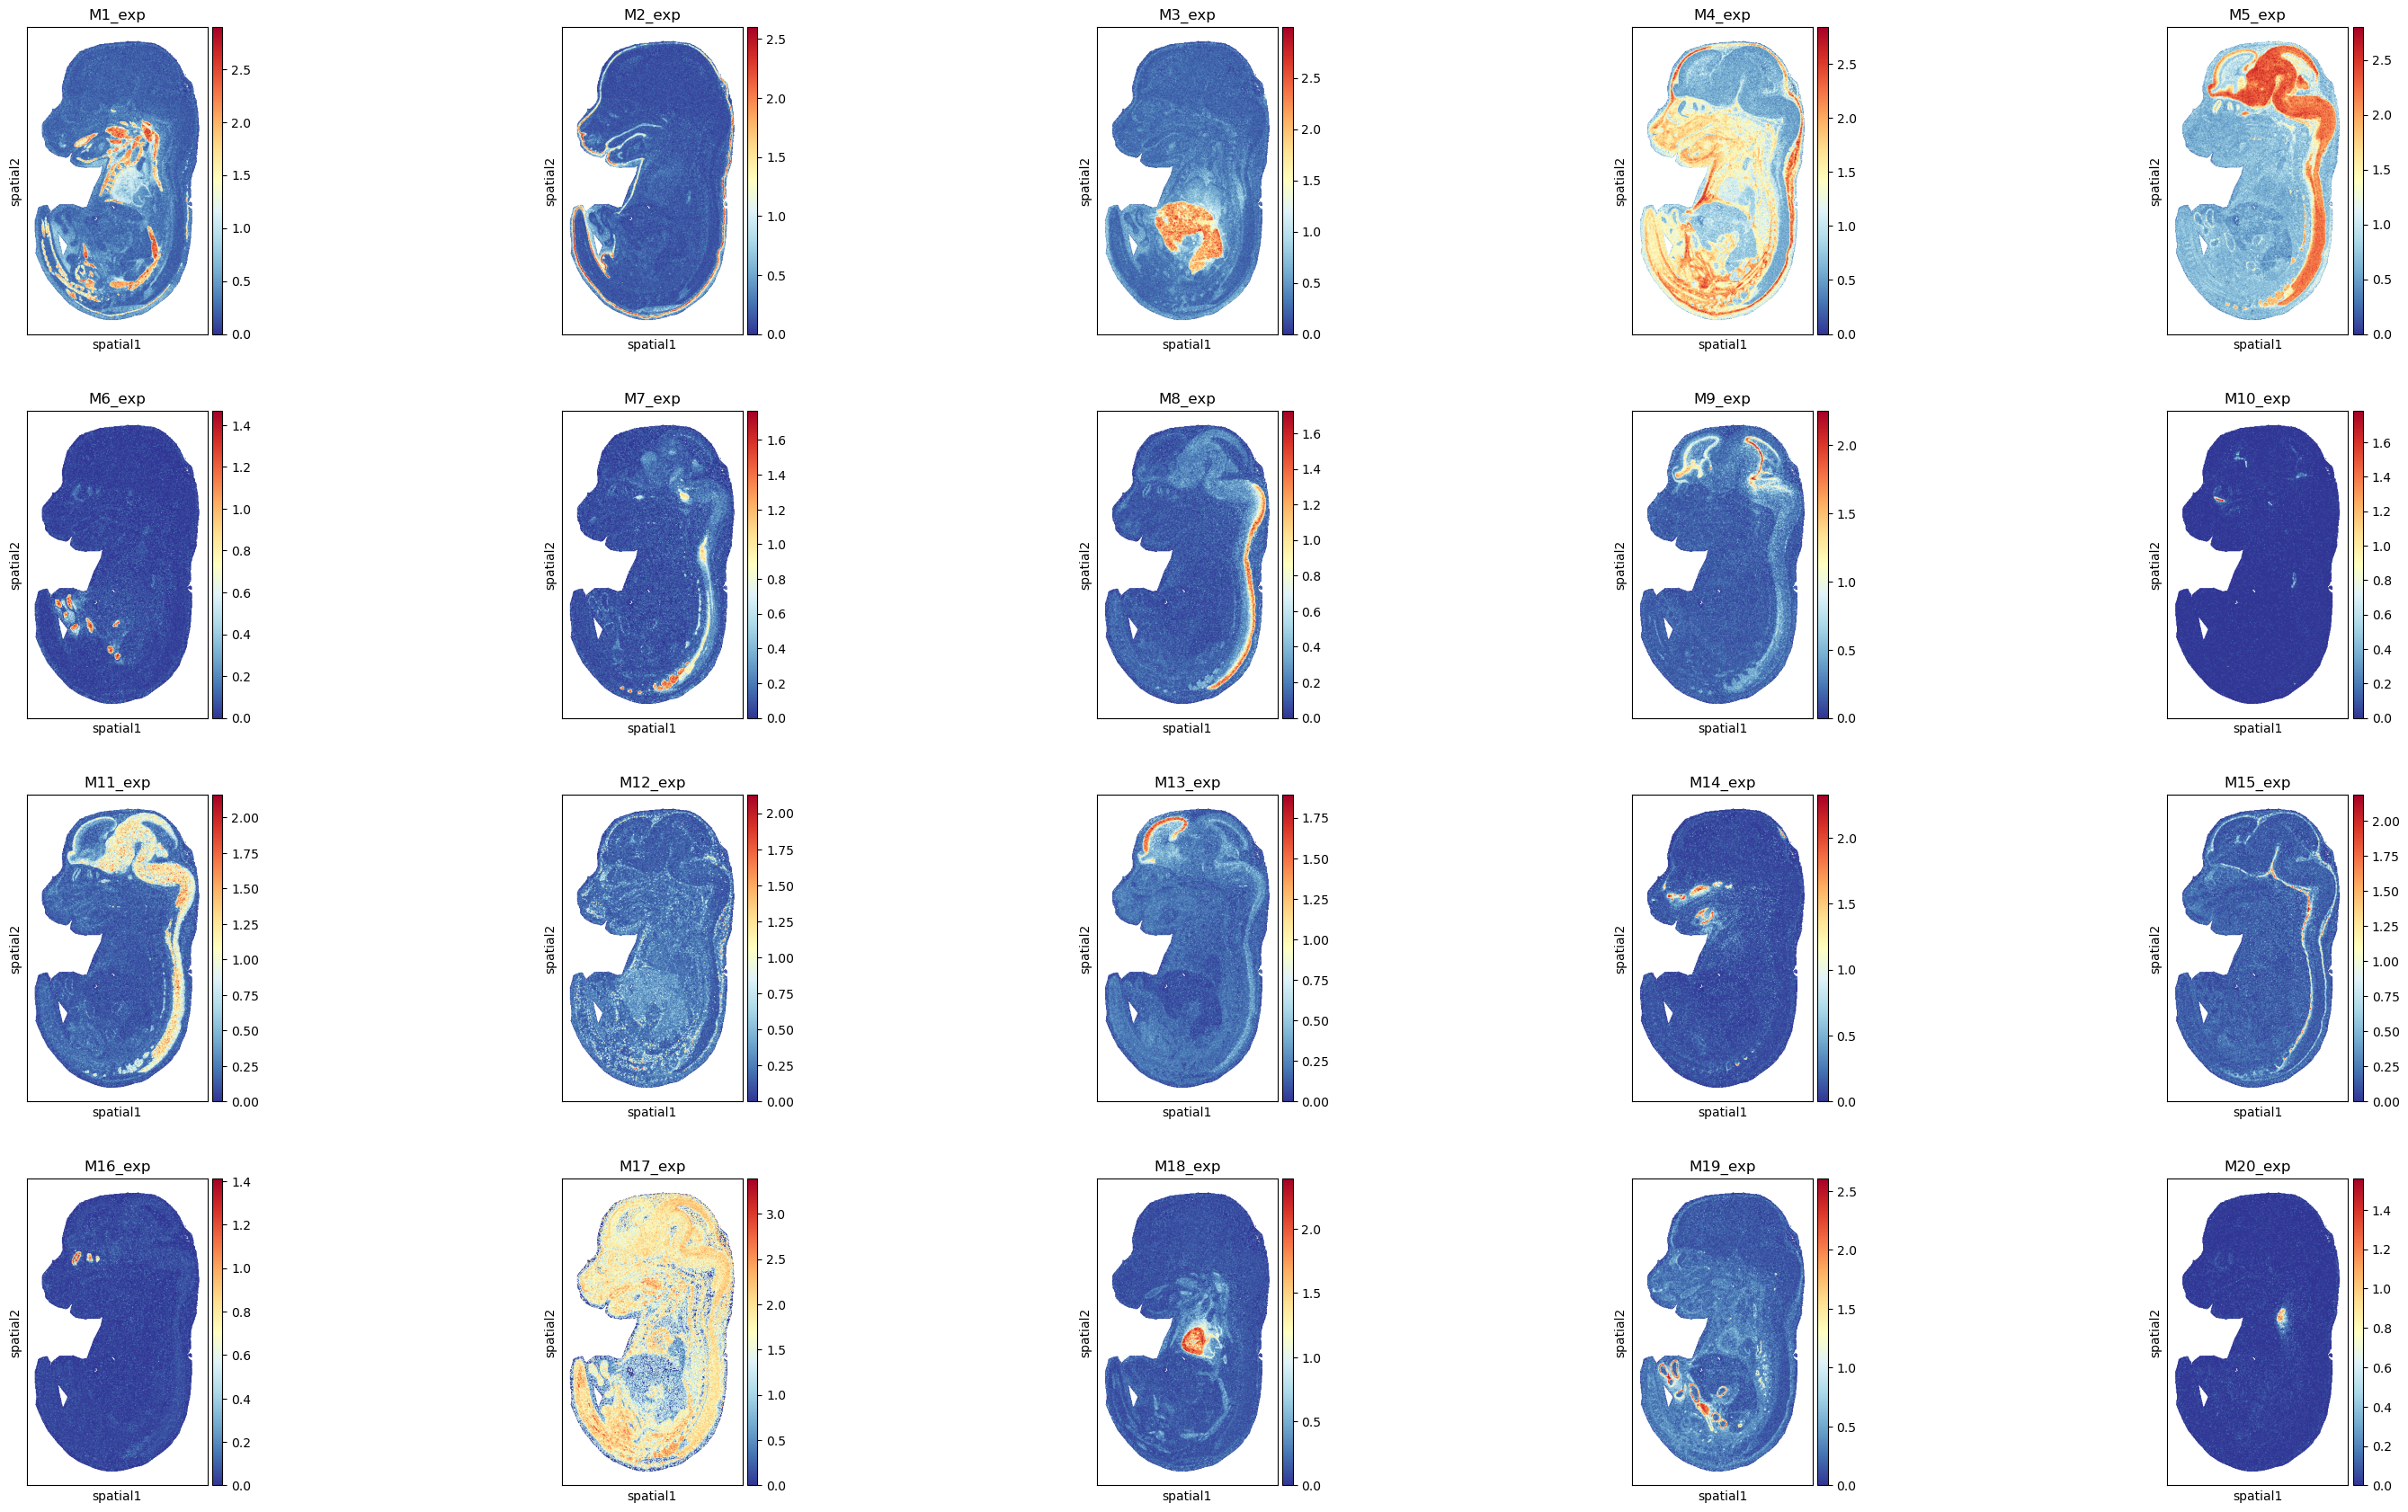

In [ ]:
# Visualize the spatial distribution of the top 20 program-expression scores.
sc.pl.spatial(adata, spot_size = 2, color=['M1_exp','M2_exp','M3_exp','M4_exp','M5_exp',
                                           'M6_exp','M7_exp','M8_exp','M9_exp','M10_exp',
                                           'M11_exp','M12_exp','M13_exp','M14_exp','M15_exp',
                                           'M16_exp','M17_exp','M18_exp','M19_exp','M20_exp'], 
              cmap='RdYlBu_r',ncols=5)

In [ ]:
# Assign spot-level annotations via Gaussian Mixture Models (GMMs) based on program expression.
sg.calculate_gmm_annotations(adata, ggm_key='ggm')

M1 processed successfully, annotated cells: 13745
M2 processed successfully, annotated cells: 8810
M3 processed successfully, annotated cells: 11143
M4 processed successfully, annotated cells: 29069
M5 processed successfully, annotated cells: 26404
M6 processed successfully, annotated cells: 1833
M7 processed successfully, annotated cells: 4039
M8 processed successfully, annotated cells: 5620
M9 processed successfully, annotated cells: 7156
M10 processed successfully, annotated cells: 389
M11 processed successfully, annotated cells: 22200
M12 processed successfully, annotated cells: 3678
M13 processed successfully, annotated cells: 2236
M14 processed successfully, annotated cells: 6027
M15 processed successfully, annotated cells: 3465
M16 processed successfully, annotated cells: 681
M17 processed successfully, annotated cells: 100930
M18 processed successfully, annotated cells: 4764
M19 processed successfully, annotated cells: 2247
M20 processed successfully, annotated cells: 715
M21 p

In [ ]:
# Optionally smooth the annotations using spatial k-NN (on the 'spatial' embedding).
sg.smooth_annotations(adata, ggm_key='ggm', embedding_key='spatial', k_neighbors=24)

M1 processed. remain cells: 15630
M2 processed. remain cells: 10424
M3 processed. remain cells: 11557
M4 processed. remain cells: 34596
M5 processed. remain cells: 27570
M6 processed. remain cells: 1948
M7 processed. remain cells: 4309
M8 processed. remain cells: 5956
M9 processed. remain cells: 7937
M10 processed. remain cells: 367
M11 processed. remain cells: 24731
M12 processed. remain cells: 2898
M13 processed. remain cells: 2353
M14 processed. remain cells: 5628
M15 processed. remain cells: 3635
M16 processed. remain cells: 551
M17 processed. remain cells: 117300
M18 processed. remain cells: 5048
M19 processed. remain cells: 2496
M20 processed. remain cells: 691
M21 processed. remain cells: 5599
M22 processed. remain cells: 4517
M23 processed. remain cells: 39330
M24 processed. remain cells: 0
M25 processed. remain cells: 43532
M26 processed. remain cells: 289
M27 processed. remain cells: 468
M28 processed. remain cells: 366
M29 processed. remain cells: 4961
M30 processed. remain 

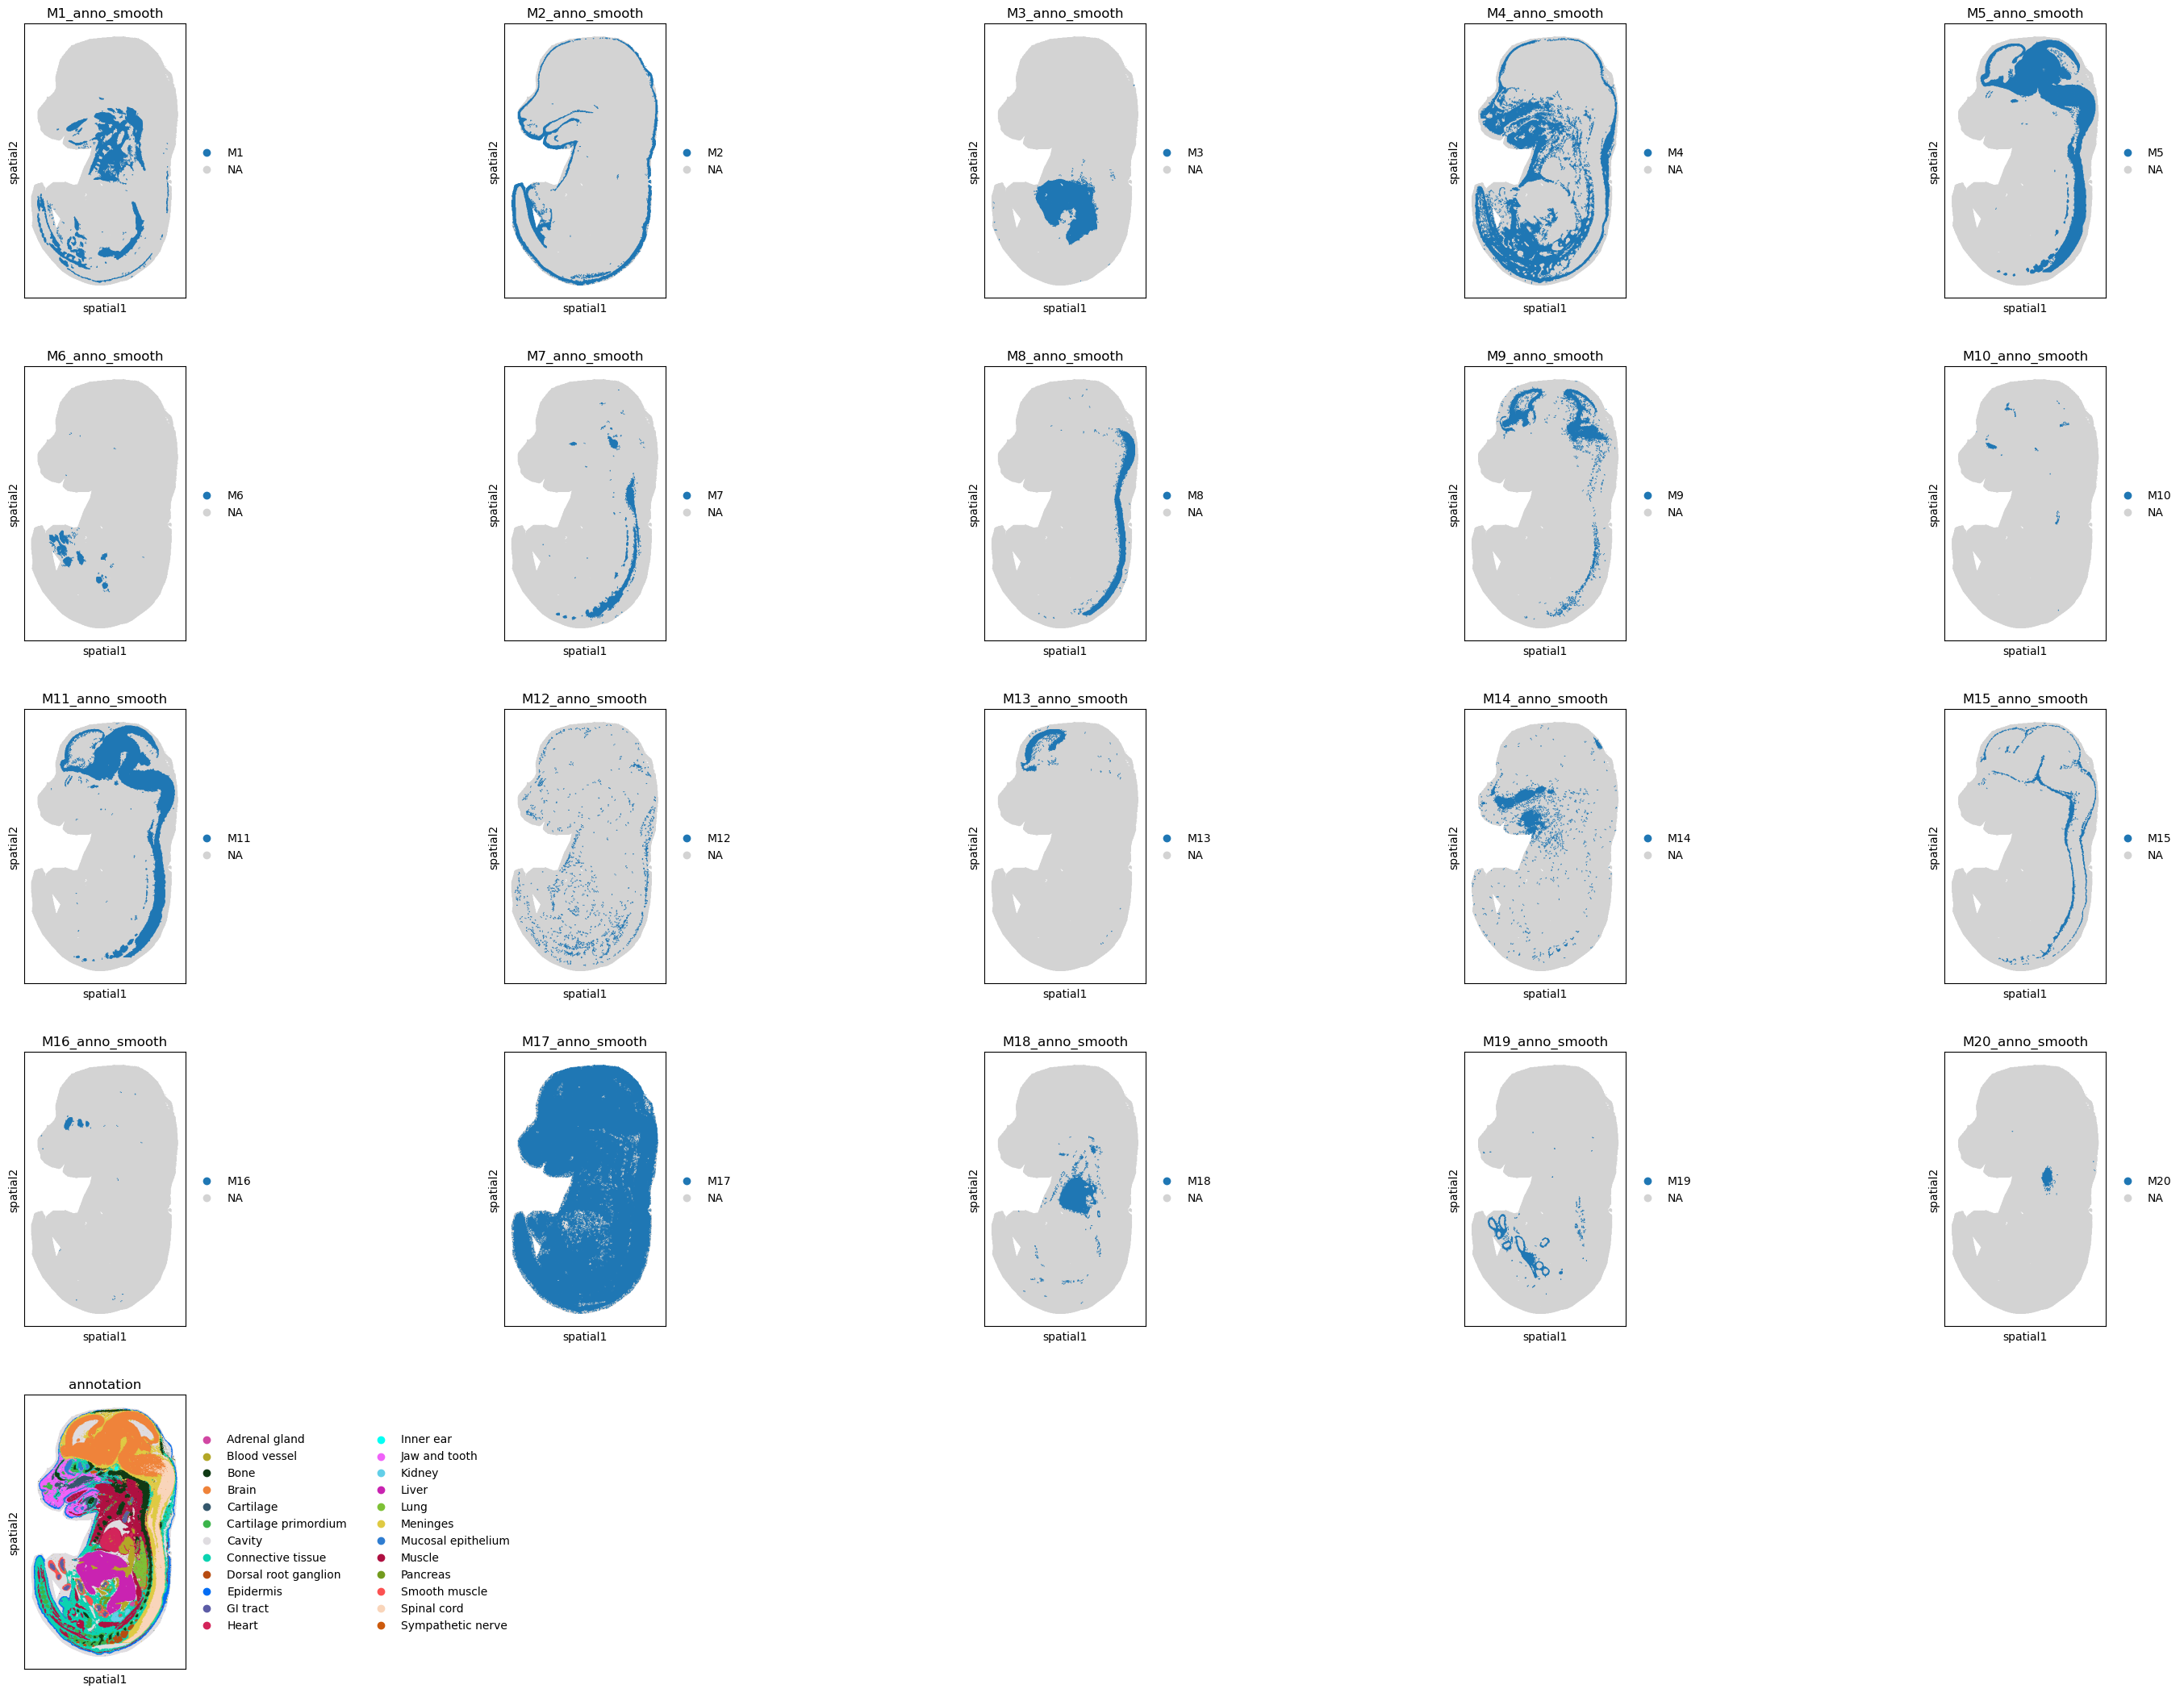

In [ ]:
# Display smoothed annotations for the top 20 programs alongside the original annotation.
# 'annotation' refers to the original labels in adata.obs['annotation'].
# If smoothing is skipped, use 'M1_anno' … 'M20_anno' instead.
sc.pl.spatial(adata, spot_size = 2, color=['M1_anno_smooth','M2_anno_smooth','M3_anno_smooth','M4_anno_smooth','M5_anno_smooth',
                                           'M6_anno_smooth','M7_anno_smooth','M8_anno_smooth','M9_anno_smooth','M10_anno_smooth',
                                           'M11_anno_smooth','M12_anno_smooth','M13_anno_smooth','M14_anno_smooth','M15_anno_smooth',
                                           'M16_anno_smooth','M17_anno_smooth','M18_anno_smooth','M19_anno_smooth','M20_anno_smooth',
                                           'annotation'], 
              ncols=5)

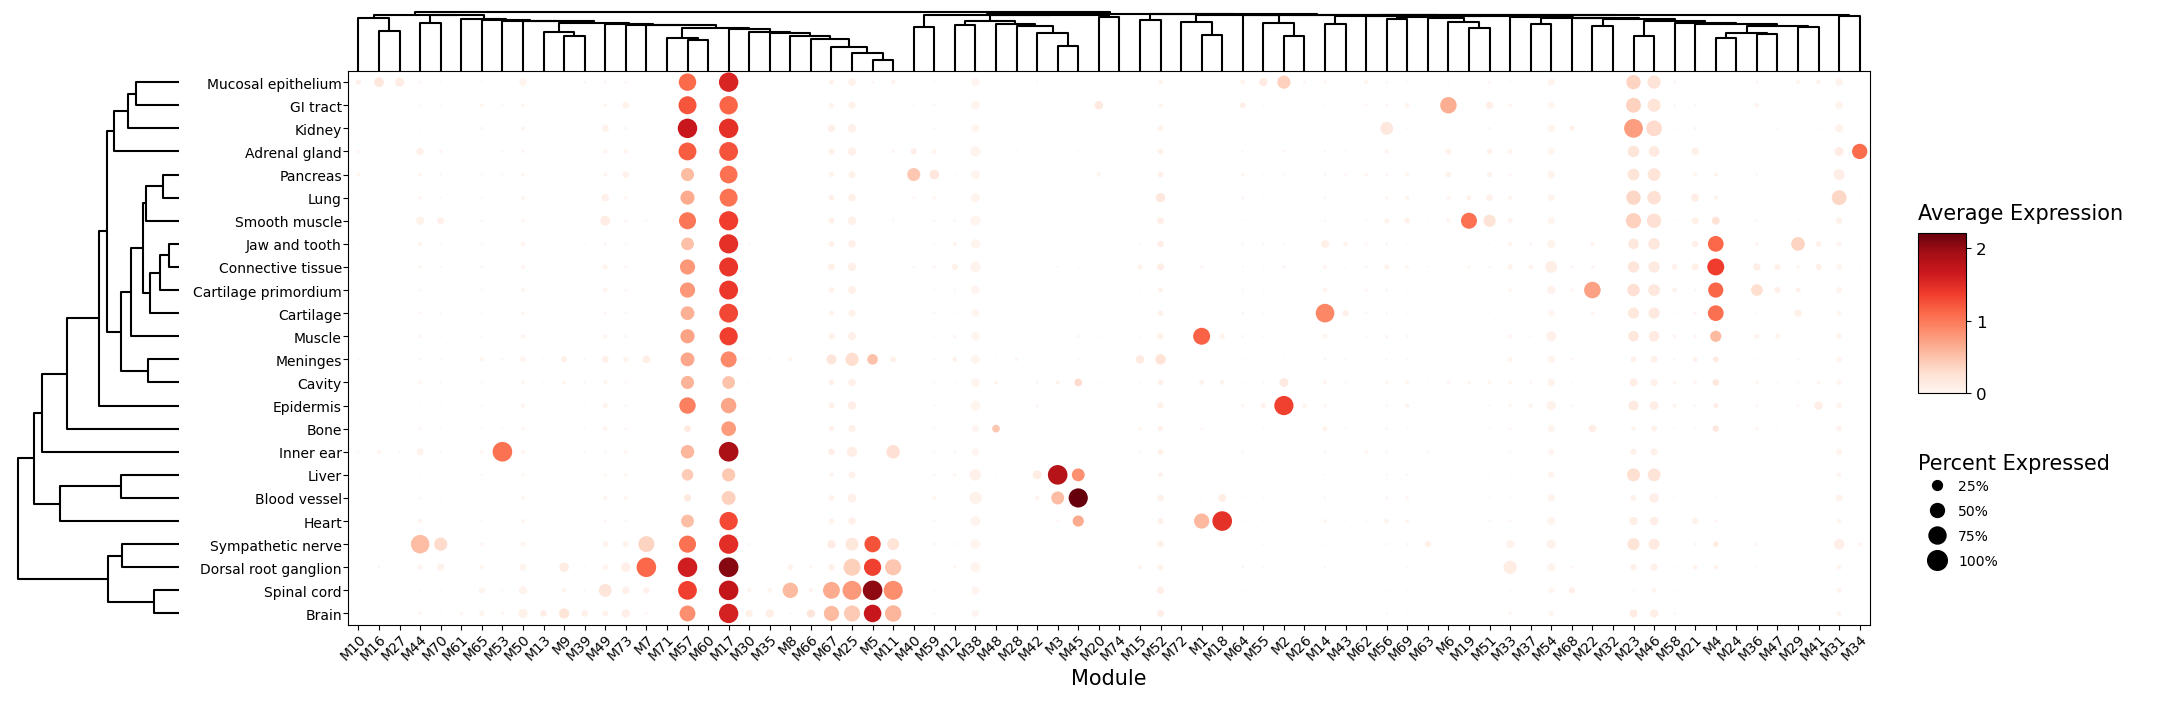

In [ ]:
# Summarize program-expression across the existing annotation categories as a dot plot.
sg.module_dot_plot(
    adata,
    ggm_key='ggm',
    groupby= 'annotation',
    dendrogram_height = 0.1,
    dendrogram_space= 0.2,
    fig_width = 24,
    axis_fontsize=10,
)

In [ ]:
# Integrate multiple program-derived annotations into a single label set via sg.integrate_annotations.
sg.integrate_annotations(adata, ggm_key='ggm',result_anno='ggm_annotation')
# Here we integrate all programs as an example. You can specify a subset of programs via the 'modules_used' parameter.


Calculating 24 nearest neighbors for each cell based on spatial embedding...


125430 of total 130944 cells have multiple annotations. Among them, 
    32770 cells are resolved by neighbors.
    92660 cells are resolved by expression score.

Integrated annotation stored in adata.obs['ggm_annotation'].



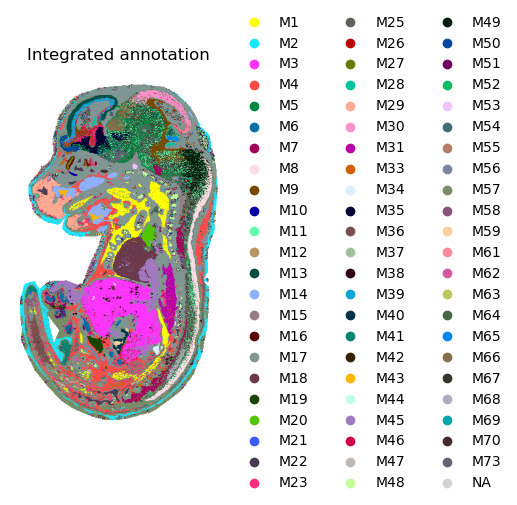

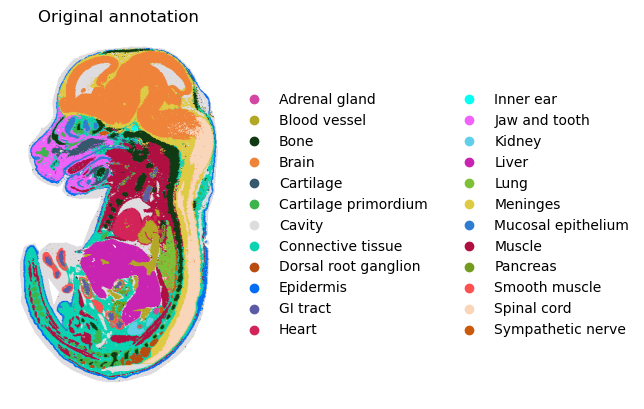

In [ ]:
# Visualize the integrated annotation and compare it to the existing annotation.
sc.pl.spatial(adata, spot_size = 2, color=['ggm_annotation'], frameon=False, title='Integrated annotation')
sc.pl.spatial(adata, spot_size = 2, color=['annotation'], frameon=False, title='Original annotation')

In [ ]:
# Save the annotated AnnData object.
adata.write("data/MOSTA_E16.5_E2S5_ggm_anno.h5ad")